<a href="https://colab.research.google.com/github/Surovytskyi/Object-Detection/blob/main/detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# installing Detectron2
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-nulrbf1o
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-nulrbf1o


In [32]:
import torch, detectron2
#from detectron2.utils.logger import setup_logger
#setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

Run a pre-trained detectron2 model

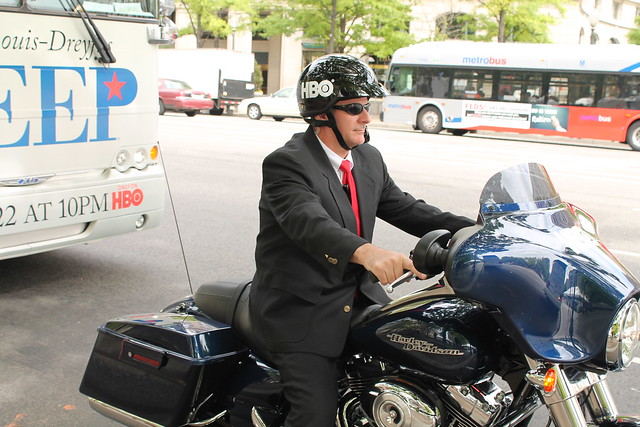

In [33]:
# first downloading an image from the COCO dataset
!wget http://farm6.staticflickr.com/5442/7092595017_8b5090b6e0_z.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

In [34]:
# we create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [35]:
# look at the outputs
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  5,  3,  2,  2, 27,  7,  7,  5, 28,  0], device='cuda:0')
Boxes(tensor([[242.0896,  54.3862, 471.5721, 425.0107],
        [386.9316,  42.1735, 640.0000, 149.8143],
        [ 88.7398, 159.8259, 635.0292, 427.0000],
        [157.2232,  78.2286, 212.7035, 116.0913],
        [239.3428,  86.0048, 302.9091, 122.0839],
        [339.6549, 159.5443, 361.2280, 237.7809],
        [159.1423,  47.4736, 257.0414, 109.5735],
        [  0.0000,   2.7201, 171.9566, 261.9003],
        [  1.0300,   4.1539, 174.5786, 266.5731],
        [ 78.7339, 295.8846, 278.3820, 422.0237],
        [464.1468,  83.1155, 484.0050,  98.1139]], device='cuda:0'))


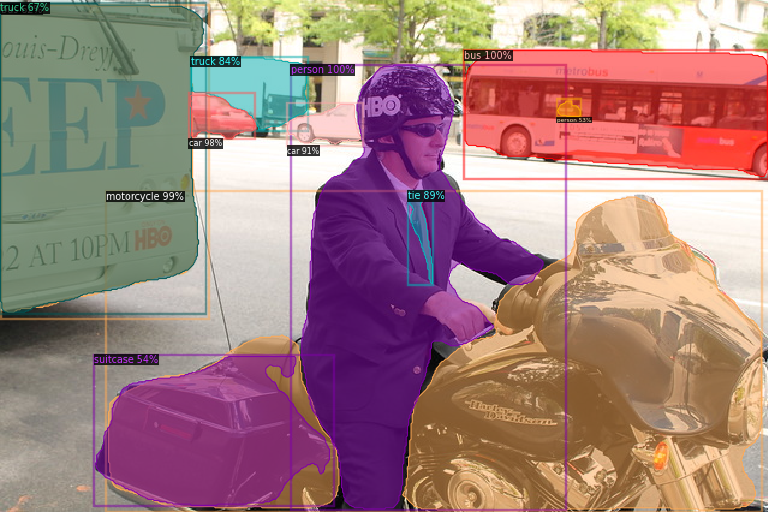

In [36]:
# drawing the predictions on the image
v = Visualizer(im, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image())

Train on a custom dataset

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# function to parse custom dataset and prepare it into detectron2's standard format
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 224
        record["width"] = 224
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
# creating a metadata for our train and test sets
classes = ['benign', 'malignant']

data_path = '/content/drive/MyDrive/image_segmentation/data/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

In [40]:
# fine-tuning a COCO-pretrained R50-FPN Mask R-CNN model on custom daraset
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[07/10 17:23:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

In [41]:
trainer.train()

[07/10 17:23:14 d2.engine.train_loop]: Starting training from iteration 0
[07/10 17:23:22 d2.utils.events]:  eta: 0:06:32  iter: 19  total_loss: 2.052  loss_cls: 1.189  loss_box_reg: 0.1381  loss_mask: 0.69  loss_rpn_cls: 0.006529  loss_rpn_loc: 0.01236  time: 0.4037  data_time: 0.0159  lr: 4.9953e-06  max_mem: 2032M
[07/10 17:23:30 d2.utils.events]:  eta: 0:06:25  iter: 39  total_loss: 1.834  loss_cls: 0.9772  loss_box_reg: 0.1374  loss_mask: 0.6843  loss_rpn_cls: 0.008938  loss_rpn_loc: 0.0101  time: 0.4064  data_time: 0.0080  lr: 9.9902e-06  max_mem: 2032M
[07/10 17:23:39 d2.utils.events]:  eta: 0:06:21  iter: 59  total_loss: 1.419  loss_cls: 0.5932  loss_box_reg: 0.1221  loss_mask: 0.6789  loss_rpn_cls: 0.01046  loss_rpn_loc: 0.008223  time: 0.4123  data_time: 0.0118  lr: 1.4985e-05  max_mem: 2032M
[07/10 17:23:47 d2.utils.events]:  eta: 0:06:16  iter: 79  total_loss: 1.121  loss_cls: 0.3176  loss_box_reg: 0.1306  loss_mask: 0.661  loss_rpn_cls: 0.004147  loss_rpn_loc: 0.008712  ti

In [42]:
# creating a predictor using the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("skin_test", )
predictor = DefaultPredictor(cfg)

[07/10 17:30:10 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

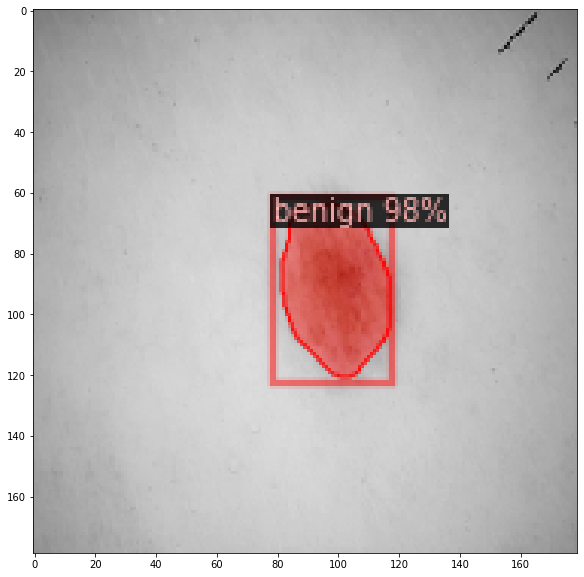

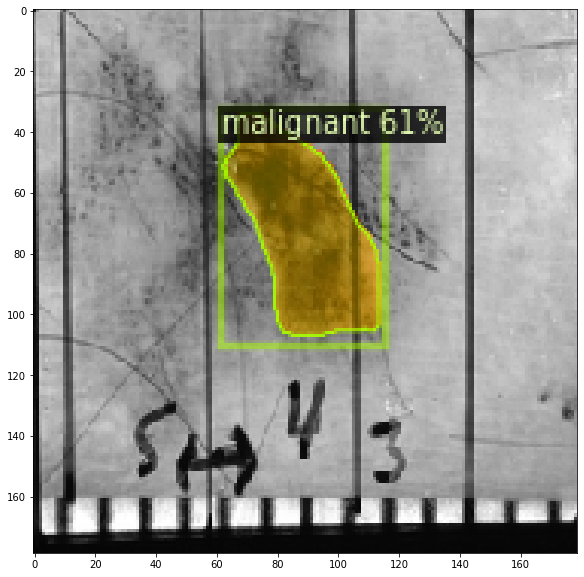

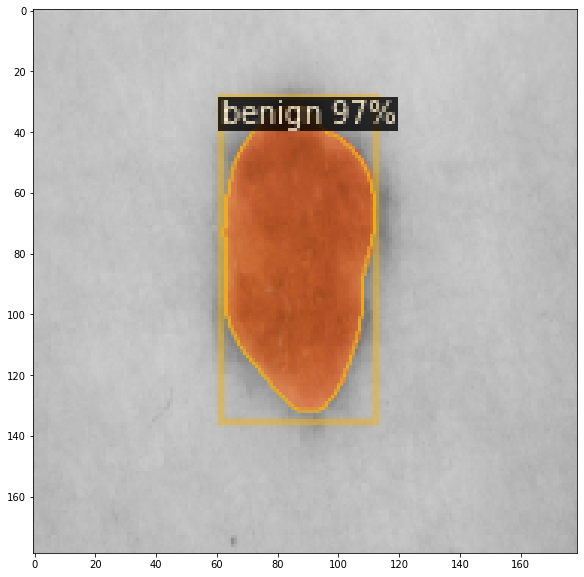

In [44]:
# randomly selecting several samples to visualize the prediction results
test_dataset_dicts = get_data_dicts(data_path+'test', classes)
for d in random.sample(test_dataset_dicts, 3):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()